In [1]:
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,Activation,Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras import layers, models, optimizers
from keras.optimizers import adam, Adam
from keras.utils import to_categorical
from keras.preprocessing import image
from skimage.transform import resize
%matplotlib inline
import matplotlib.pyplot as plt
from keras import initializers
from keras import backend as K
from keras.models import Model
from keras.layers import *
from urllib import request
import tensorflow as tf
from skimage import io
from lxml import etree
from PIL import Image
from keras import *
import numpy as np
import tarfile
import keras

import glob
import sys
import cv2
import os
import re


print("TensorFlow Version : ", tf.__version__)
print("Open CV Version : ",cv2.__version__)
print("Keras Version : ", keras.__version__)

Using TensorFlow backend.


TensorFlow Version :  2.2.0
Open CV Version :  4.1.2
Keras Version :  2.3.1


In [2]:
#Here we mount the google drive to save our trained model weights
'''from google.colab import drive
drive.mount('/content/gdrive')'''

"from google.colab import drive\ndrive.mount('/content/gdrive')"

We download the PASCAL VOC 2009 dataset and save it into a local folder. The downloaded dataset is extracted into the folder **/content/sample_data/PascalVOC/**. As long as the runtime is connected, the data set will be present in the downloaded location and will be loaded into the variables. Once, the run-time gets disconnected or the Colab Notebook is closed, the dataset will be downloaded again and saved into the below mentioned folder.


In [3]:
basePath = "/content/sample_data/PascalVOC/"

if not os.path.isdir(basePath):
  os.makedirs(basePath)

pascalVOCDataSetURL = "http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar"

if os.path.isfile(basePath+"VOCtrainval_11-May-2009.tar"):
  print("VOCtrainval_11-May-2009.tar already exists in the folder {}".format(basePath))
  if len(os.listdir(basePath+"VOCdevkit") ) == 0:
    print("Directory is empty")
    os.system("rm -rf /content/sample_data/VOCdevkit/")
    with tarfile.open(os.path.join(basePath, "VOCtrainval_11-May-2009.tar")) as f:
      f.extractall(os.path.join(basePath))
  else:    
    print("Data sets are already downloaded and is present in the directory {}".format(basePath))

else:
  print("Downloading file VOCtrainval_11-May-2009.tar from {}".format(pascalVOCDataSetURL))
  print("This might take few minutes !!!")
  with request.urlopen(pascalVOCDataSetURL) as r, open(os.path.join(basePath, "VOCtrainval_11-May-2009.tar"), 'wb') as f:
    f.write(r.read())
  print("Download Complete !!!")
  print("Extracting the data sets into the folder {}".format(basePath))
    # extract
  with tarfile.open(os.path.join(basePath, "VOCtrainval_11-May-2009.tar")) as f:
    f.extractall(os.path.join(basePath))
  print("Data set extraction Complete !!!")

This might take few minutes !!!
Download Complete !!!
Extracting the data sets into the folder /content/sample_data/PascalVOC/
Data set extraction Complete !!!


In [5]:
dataSetDirectory = basePath + "VOCdevkit/VOC2009/"
imgageDirectory = os.path.join(dataSetDirectory, 'JPEGImages')
annotationsDirectory = os.path.join(dataSetDirectory, 'Annotations')
segFolder = os.path.join(dataSetDirectory, 'ImageSets', 'Segmentation')
setDirectory = os.path.join(dataSetDirectory, 'ImageSets', 'Main')
annotationFiles = os.listdir(annotationsDirectory)
classesFiles = os.listdir(setDirectory)

For segmentation, the models takes an image as input and outputs another image with segmented objects. Since, we are performing supervised learning, the target for a segmentation model is a segmented image with different colors. Each color is associated to a class of the object. Therefore, to train the segmentation model, it is necessary to encode the target image colors to its corresponding classes. The COLORMAP list shows the color values (RGB) for each class.

**Note:** Here the color palette for the boundary around a segmented object is not considered

In [6]:
COLORMAP = [[0,0,0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


CM2CLASS = np.zeros(256 ** 3) # every pixel 0~255，RGB 3 channel

for i,cm in enumerate(COLORMAP):
    CM2CLASS[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i # build index

n_classes = len(CLASSES)
id2code = {k:v for k,v in enumerate(COLORMAP)}
image_size = 224

The data set images for each class are provided in a **.txt** file for training and validation images respectively. Rather than using the seperate **train.txt** and **val.txt** files, we load the complete data set using **trainval.txt** file. Every class has its own **trainval.txt**, therefore in the below cell we read all the files in on go. The dataset is later divided into train and test and validation sets from the full dataset. 

In [8]:
txtFiles = [os.path.join(setDirectory, cf) for cls in CLASSES for cf in classesFiles if cls in cf and cls+'_trainval.txt' in cf] #List all the train files
txtFiles_segmentation = os.path.join(segFolder, 'trainval.txt')

In [9]:
def get_target(img_path):
    """
     For segmentation task, read color image, transform it to 3-d one-hot encodeing class target image.
    :param img_path: the image path
    :return: target: (image_size,image_size,21)
    """
    label_im = Image.open(img_path).convert('RGB')
    im = label_im.resize((image_size, image_size), Image.ANTIALIAS)

    data = np.array(im, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    label_map =  np.array(CM2CLASS[idx], dtype='int64') # 2-d class map, class of every pixel

    return label_map

The below function labels2colors() maps the target images back to its original color palette.

**Note:** Since, we have not considered the color palette of the object boundaries, the mapping back will give a image without the boundary. 

In [10]:
def labels2colors(labels, cmap):
    """
    Converts a matrix of labels (ie. pixels' semantic class) to an image with their equivalent color.
    :param labels: a matrix of class labels
    :param cmap: the color map, as a list of RGB tuples:
     - The first item is the background class color,
     - The last item is the color of the void/ignore class
    :return: an image with colorized pixels' class
    """
    labels_colored = np.zeros((*labels.shape, 3), dtype='uint8')
    for label in np.unique(labels):
        label_mask = labels == label
        label_mask = np.dot(np.expand_dims(label_mask, axis=2), np.array(cmap[label]).reshape((1, -1)))
        labels_colored += label_mask.astype('uint8')
    return labels_colored

In [11]:
def get_segmentation_dataset(seg_file):
    with open(seg_file) as file:
        lines = file.read().splitlines()
        train_filter = [line.strip() for line in lines]

    image_folder = os.path.join(dataSetDirectory, "JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype('float32')

    seg_folder = os.path.join(dataSetDirectory, "SegmentationClass/")
    image_filenames = [os.path.join(seg_folder, file) for f in train_filter for file in os.listdir(seg_folder) if f in file]
    y = np.array([get_target(img_f) for img_f in image_filenames])

    return x, y


In [12]:
print("Loading the segmentation dataset !!! Please be patient")
X_seg, Y_seg = get_segmentation_dataset(txtFiles_segmentation)
print("Loading the segmentation dataset is complete !!!")

Loading the segmentation dataset !!! Please be patient
Loading the segmentation dataset is complete !!!


In [13]:
np.random.seed(12)
Xtrain_seg, Xtest_seg, Ytrain_seg, Ytest_seg = train_test_split(X_seg,Y_seg,test_size=0.1, random_state=12)
print("Segmentation Training Images Size:", Xtrain_seg.shape)
print("Segmentation Training Labels Size:", Ytrain_seg.shape)
print("Segmentation Test Images Size:", Xtest_seg.shape)
print("Segmentation Test Labels Size:", Ytest_seg.shape)

Segmentation Training Images Size: (1349, 224, 224, 3)
Segmentation Training Labels Size: (1349, 224, 224)
Segmentation Test Images Size: (150, 224, 224, 3)
Segmentation Test Labels Size: (150, 224, 224)


Here we delete the full data set variables to free the memory

In [14]:
del X_seg
del Y_seg

The below function plot_seg_data_pairs() plots the original image and the corresponding segmentaion label. Here we randomly plot 5 different images and its labels

In [15]:
def plot_seg_data_pairs(img, label):
  fig, ax = plt.subplots(figsize=(5, 5))
  plt.subplot(121)
  plt.imshow(img)
  plt.title("Image Feature")
  plt.subplot(122)
  plt.imshow(label)
  plt.title("Image Label")

  plt.show()

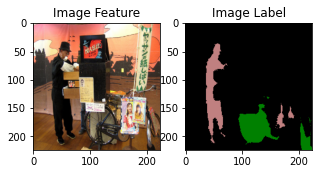

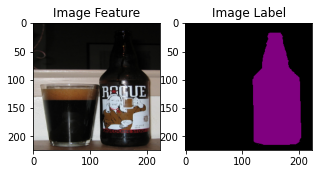

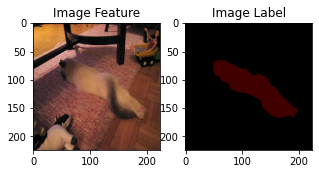

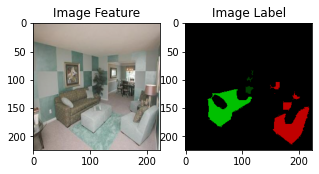

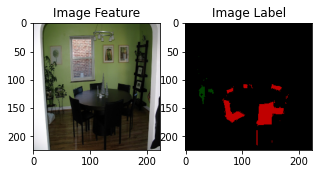

In [16]:
for i in range(5):
  plot_seg_data_pairs(Xtrain_seg[i],labels2colors(Ytrain_seg[i],COLORMAP))

# 1 Supervised, end-to-end learning

##1.1 Semantic Segmentation
The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. 

Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction. The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. 

Thus it is a pixel level image classification.

For our task, we use a UNet architecture with VGG backbone for training the segmentation model. Just like the classification model, we train the segmentation models as well from scratch and using transfer learning techniques. 

###1.1.1 Semantic Segmentation end-to-end

The UNET architecture contains two paths. First path is the called as the encoder which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path called as the decoder which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

The UNet architecture is as follows

![Unet](https://miro.medium.com/max/1400/1*OkUrpDD6I0FpugA_bbYBJQ.png)

The network uses something called as skip connections.  It means skipping some layers in the neural network and feeding the output of one layer to another layer skipping a few layers in between. Usually, some information is captured in the initial layers and is required for reconstruction during the up-sampling done using the fully connected network layer. An information that we have in the primary layers can be fed explicitly to the later layers using the skip architecture.

Skip connections also help traverse information faster in deep neural networks. Gradient information can get lost as we pass through multiple layers as we have problems of vanishing gradient descent. Advantages of skip connection are they pass information to lower layers so using it to classify minute details becomes easier.

Here in our architecture we use the skip connections as well.


[Image Source and Reference :] [Understanding Semantic Segmentation with UNET](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

In [17]:
def vggEncoder(input_height=image_size,  input_width=image_size):
  img_input = Input(shape=(input_height, input_width, 3))
  x = Conv2D(input_shape=(224,224,3),filters=64, name='block1_conv2D_1',kernel_size=(3,3),padding="same", activation="relu")(img_input)
  x = Conv2D(filters=64,kernel_size=(3,3),name='block1_conv2D_2', padding="same", activation="relu")(x)
  f1 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2),name='block1_maxpool_2D')(x)

  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", name='block2_conv2D_1', activation="relu")(x)
  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", name='block2_conv2D_2',activation="relu")(x)
  f2 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2), name='block2_maxpool_2D')(x)
  
  x = Conv2D(filters=256, kernel_size=(3,3), name='block3_conv2D_1',padding="same", activation="relu")(x)
  x = Conv2D(filters=256, kernel_size=(3,3), name='block3_conv2D_2',padding="same", activation="relu")(x)
  x = Conv2D(filters=256, kernel_size=(3,3), name='block3_conv2D_3',padding="same", activation="relu")(x)
  f3 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2),name='block3_maxpool_2D')(x)
  
  x = Conv2D(filters=512, kernel_size=(3,3), name='block4_conv2D_1', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block4_conv2D_2', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block4_conv2D_3', padding="same", activation="relu")(x)
  f4 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2), name='block4_maxpool_2D')(x)
  
  x = Conv2D(filters=512, kernel_size=(3,3), name='block5_conv2D_1', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block5_conv2D_2', padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), name='block5_conv2D_3', padding="same", activation="relu")(x)
  f5 = x
  x = MaxPool2D(pool_size=(2,2),strides=(2,2), name='block5_maxpool_2D' )(x)

  return img_input, x , [f1, f2, f3, f4, f5]

As said above, the below functions implement the encoder and decoder blocks of the UNet architecture. Since, the output of the model should be an image, the activation here is **he_normal** rather than a sigmoid or softmax. Also, we use some skip connections as discussed above that can be seen in the below architecture.

In [18]:
def unetDecoderBlock(filter,input,concat,concat_encoder):
    up_conv = BatchNormalization()(Conv2D(filters=filter,kernel_size=(2,2),activation='relu',padding='same',
                                          kernel_initializer='he_normal')(UpSampling2D(size=(2,2),interpolation='bilinear')(input)))
    if concat:
        merge = concatenate([concat_encoder,up_conv])
    else:
        merge = up_conv
    conv1 = BatchNormalization()(Conv2D(filters=filter,kernel_size=(3,3),activation='relu',padding='same',
                                        kernel_initializer='he_normal')(merge))
    conv2 = BatchNormalization()(Conv2D(filters=filter, kernel_size=(3, 3), activation='relu', padding='same',
                                        kernel_initializer='he_normal')(conv1))

    return conv2

In [19]:
def unet(n_classes, input_height=image_size, input_width=image_size):
  img_input, vggOut, filters = vggEncoder(input_height=input_height, input_width=input_width)
  [ftr1, ftr2, ftr3, ftr4, ftr5] = filters

  conv1 = Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(vggOut)
  conv2 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
  decoder_input = Dropout(0.5)(conv2)

  decoder1 = unetDecoderBlock(filter=512,input=decoder_input,concat_encoder = ftr5, concat=True)
  decoder2 = unetDecoderBlock(filter=256,input=decoder1,concat_encoder = ftr4, concat=True)
  decoder3 = unetDecoderBlock(filter=128,input=decoder2,concat_encoder = ftr3,concat=True)
  decoder4 = unetDecoderBlock(filter=64,input=decoder3,concat_encoder = ftr2,concat=True)
  decoder5 = unetDecoderBlock(filter=64, input=decoder4, concat_encoder = ftr1, concat=False)

  Out =  Conv2D(filters=n_classes,kernel_size=(1,1),activation='relu',padding='same',
                    kernel_initializer='he_normal',name='seg_output')(decoder5)
  unetModelOut = Model(img_input, Out)

  return unetModelOut

In [20]:
learning_rate_seg = 0.0001
EPOCHS_seg = 75
smooth = 1

Unlike the traditional loss functions, we use Dice loss defined Dice=2|A∩B||A|+|B|. The dice loss is calculated based on the overlap values of two functions whihc makes it suitable for our use case.

Another loss function that can be used is softmax cross entropy loss that deals with functions based on the maximum cross entropy. 

**Note:** After trying out multiple losses, we use dice loss for our task as it gives better results

In [21]:
def dice_coef(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    y_true = K.one_hot(tf.compat.v1.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1])
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [22]:
def softmax_sparse_crossentropy(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    log_softmax = tf.nn.log_softmax(y_pred)

    y_true = K.one_hot(tf.compat.v1.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1])
    unpacked = tf.unstack(y_true, axis=-1)
    y_true = tf.stack(unpacked[:], axis=-1)

    cross_entropy = -K.sum(y_true * log_softmax, axis=1)
    cross_entropy_mean = K.mean(cross_entropy)

    return cross_entropy_mean

In [23]:
unet_seg_scratch_model = unet(n_classes, input_height=image_size, input_width=image_size)

In [24]:
unet_seg_scratch_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv2D_1 (Conv2D)        (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2D_2 (Conv2D)        (None, 224, 224, 64) 36928       block1_conv2D_1[0][0]            
__________________________________________________________________________________________________
block1_maxpool_2D (MaxPooling2D (None, 112, 112, 64) 0           block1_conv2D_2[0][0]            
____________________________________________________________________________________________

Here we compile and train the model with the dice loss and dice co-efficient as the metrics. The dice co-efficient gives the value of the maximum overlap between two functions. Therefore, when we reduce the dice loss, it means we are trying to maximize the overlap between the two functions

The training part here is commented as the model weights are saved. Due to less of training images, the validation-split is done only with a factor of 0.12

In [25]:
unet_seg_scratch_model.compile(optimizer=Adam(lr=learning_rate_seg,decay=learning_rate_seg/EPOCHS_seg),loss=dice_coef_loss, metrics=[dice_coef])


Instructions for updating:
Use `tf.cast` instead.


In [26]:
seg_scratch_model_history = unet_seg_scratch_model.fit(Xtrain_seg, Ytrain_seg, batch_size = 24, epochs = EPOCHS_seg, validation_split=(0.12), shuffle=True)

Train on 1187 samples, validate on 162 samples
Epoch 1/75
1187/1187 [==============================] - 49s 41ms/step - loss: 0.7014 - dice_coef: 0.3016 - val_loss: 0.4929 - val_dice_coef: 0.5077
Epoch 2/75
1187/1187 [==============================] - 34s 29ms/step - loss: 0.2907 - dice_coef: 0.7102 - val_loss: 0.5338 - val_dice_coef: 0.4670
Epoch 3/75
1187/1187 [==============================] - 34s 29ms/step - loss: 0.2154 - dice_coef: 0.7846 - val_loss: 0.4261 - val_dice_coef: 0.5746
Epoch 4/75
1187/1187 [==============================] - 34s 29ms/step - loss: 0.1991 - dice_coef: 0.8012 - val_loss: 0.3551 - val_dice_coef: 0.6456
Epoch 5/75
1187/1187 [==============================] - 34s 29ms/step - loss: 0.1910 - dice_coef: 0.8095 - val_loss: 0.3323 - val_dice_coef: 0.6685
Epoch 6/75
1187/1187 [==============================] - 34s 29ms/step - loss: 0.1856 - dice_coef: 0.8147 - val_loss: 0.2976 - val_dice_coef: 0.7033
Epoch 7/75
1187/1187 [==============================] - 34s 29ms/

Here we plot the loss and dice co-efficients of the training process.

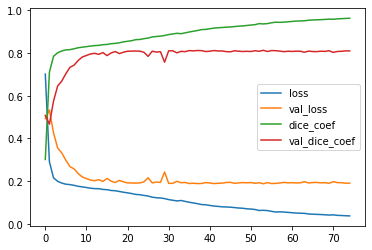

In [42]:
for key in ['loss', 'val_loss',  'dice_coef', 'val_dice_coef' ]:
    plt.plot(seg_scratch_model_history.history[key],label=key)
plt.legend()
plt.show()


In [27]:
'''save_seg_model_name = 'Segmentation_FromScratch_Weights.h5'
unet_seg_scratch_model.save_weights('/content/gdrive/My Drive/'+save_seg_model_name)'''

"save_seg_model_name = 'Segmentation_FromScratch_Weights.h5'\nunet_seg_scratch_model.save_weights('/content/gdrive/My Drive/'+save_seg_model_name)"

In [28]:
y_pred_seg_scratch = unet_seg_scratch_model.predict(Xtest_seg)
y_pred_seg_scratch_max = np.argmax(y_pred_seg_scratch, axis=3)

We then predict the segmentation images on the test set. It can be seen that the output of the from the scratch segmentation model is not that great. This is because there are only few training images and the number of trainable parameters are huge.

The below function calculates the Intersection over Union **(IOU)** for the model predicitons and the ground truth labels. The model performance and IOU is not upto the mark.

In [29]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = len(CLASSES)
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {}:            #TP={:6.0f},            #FP={:6.0f},            #FN={:5.0f},            IoU={:4.3f}".format(CLASSES[c],TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_ _ _ _ _ _ _ _ _ _ _ _ _  _ _ _ _ _")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(Ytest_seg,y_pred_seg_scratch_max)

class background:            #TP=5945715,            #FP=1080091,            #FN=106750,            IoU=0.834
class aeroplane:            #TP=  4440,            #FP=  9065,            #FN=14925,            IoU=0.156
class bicycle:            #TP=     0,            #FP=     0,            #FN= 1050,            IoU=0.000
class bird:            #TP=  4435,            #FP=104267,            #FN=41109,            IoU=0.030
class boat:            #TP=    17,            #FP=   129,            #FN=54450,            IoU=0.000
class bottle:            #TP=   155,            #FP=  7620,            #FN=33547,            IoU=0.004
class bus:            #TP= 12739,            #FP= 28682,            #FN=169104,            IoU=0.061
class car:            #TP=  1020,            #FP=  2476,            #FN=130405,            IoU=0.008
class cat:            #TP=   271,            #FP=  3636,            #FN=128909,            IoU=0.002
class chair:            #TP=    26,            #FP= 33058,            #F

In [30]:
def plot_seg_out_pairs(feature_image, pred_img, label_img):
  fig = plt.figure(figsize=(8,8))    
  ax = fig.add_subplot(1,3,1)
  ax.imshow(feature_image)
  ax.set_title("Feature Image")
    
  ax = fig.add_subplot(1,3,2)
  ax.imshow(labels2colors(pred_img, COLORMAP))
  ax.set_title("Predicted Class")
    
  ax = fig.add_subplot(1,3,3)
  ax.imshow(labels2colors(label_img, COLORMAP))
  ax.set_title("Ground Truth Class")


  plt.show()

We plot few of the model predictions and we can see, the predicted segmentation images are not that great. This is because of the lesser number of training images.

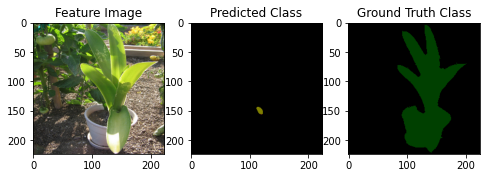

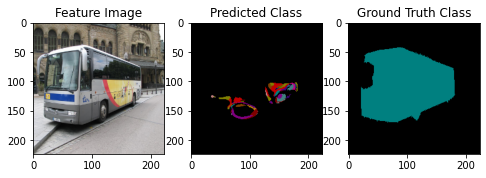

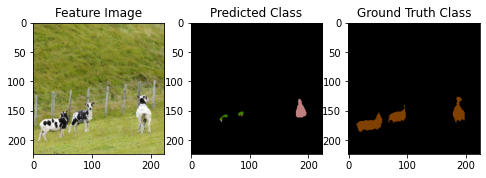

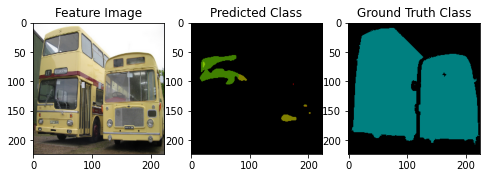

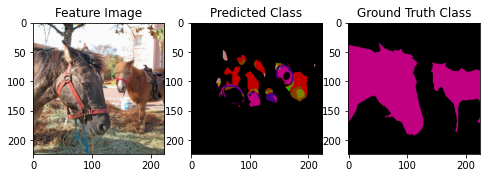

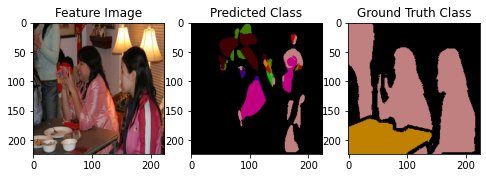

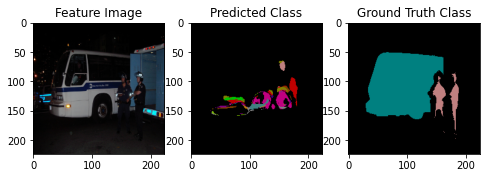

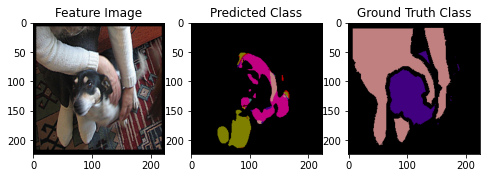

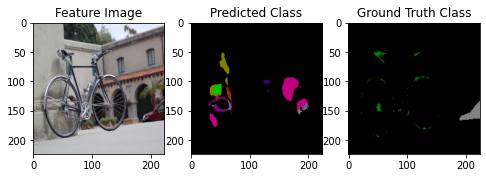

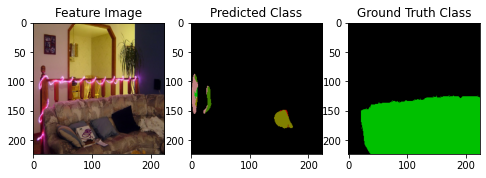

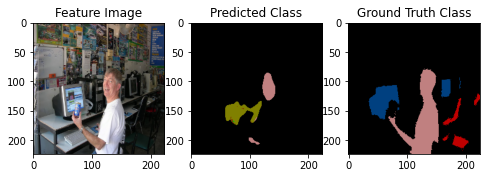

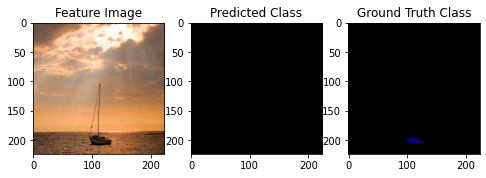

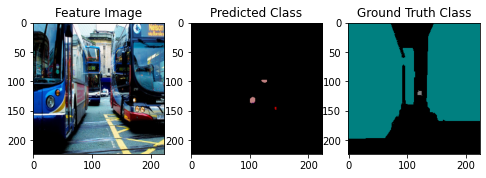

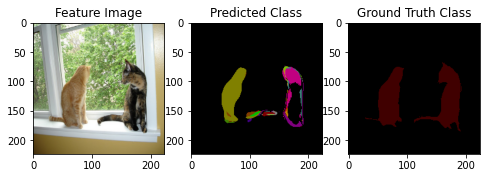

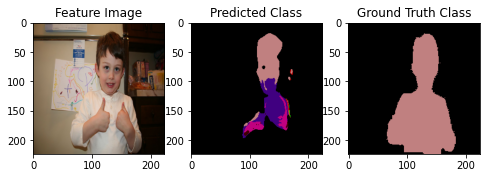

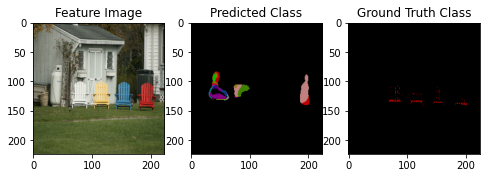

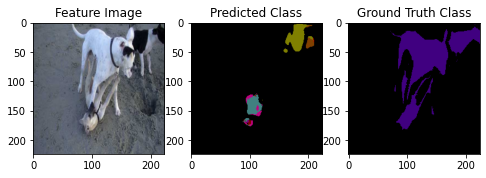

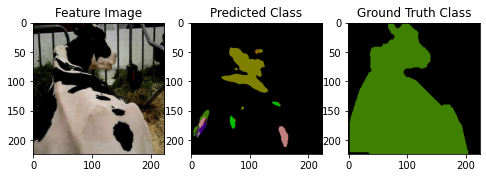

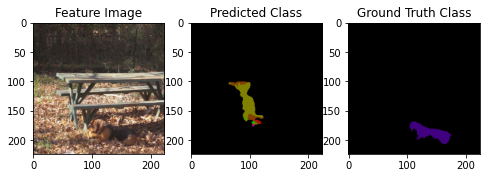

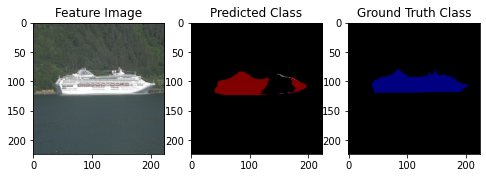

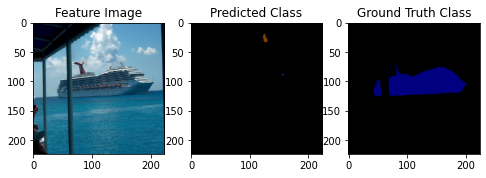

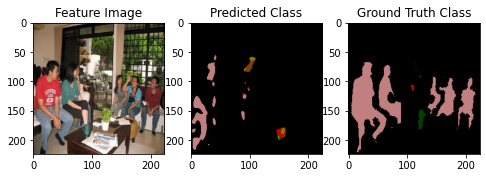

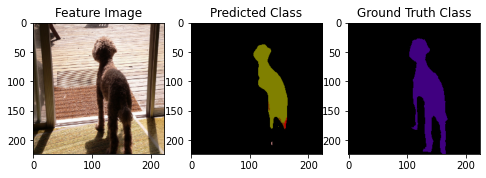

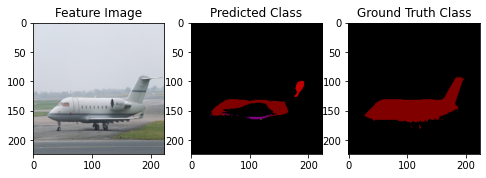

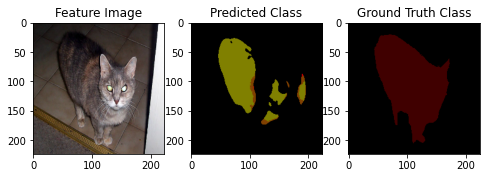

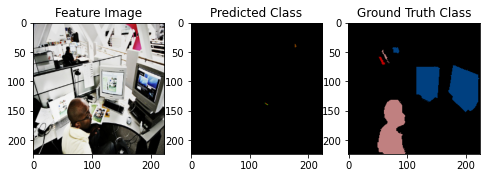

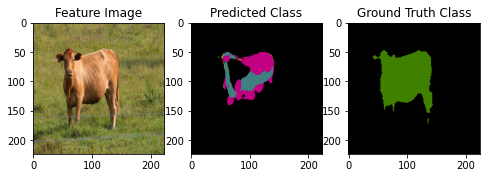

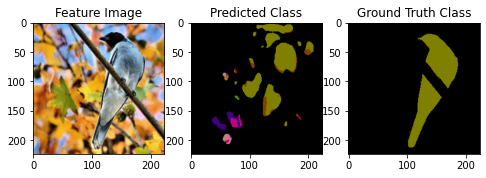

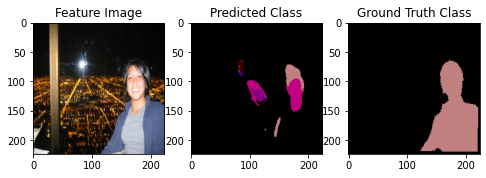

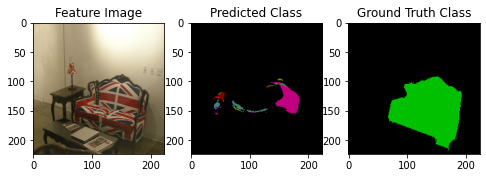

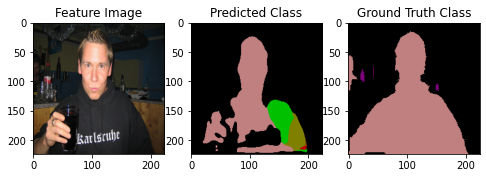

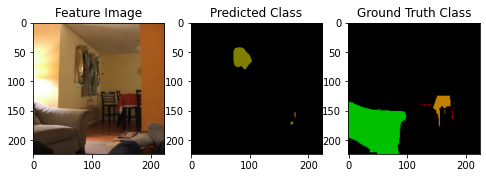

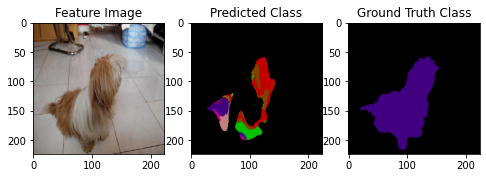

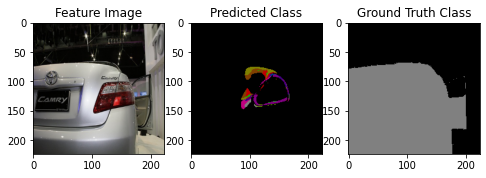

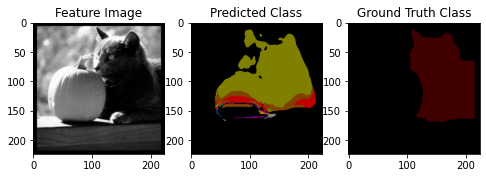

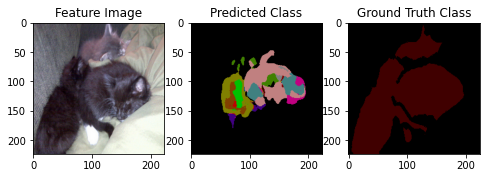

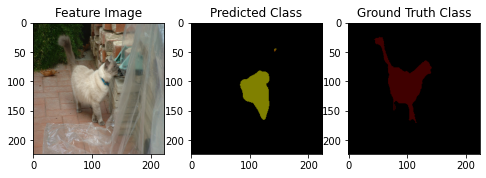

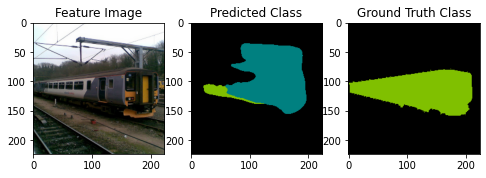

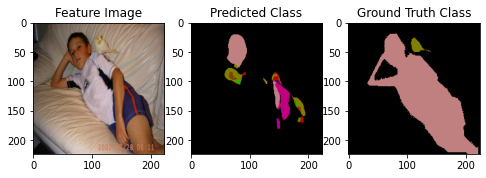

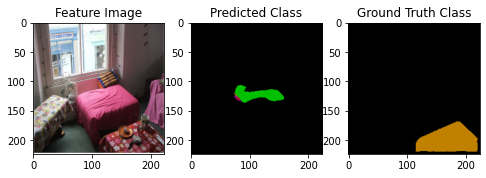

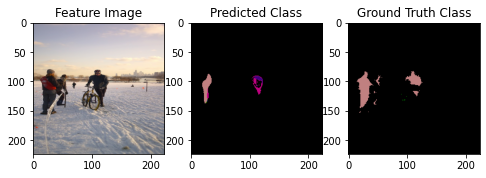

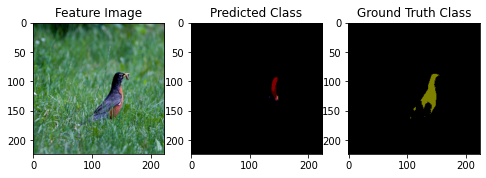

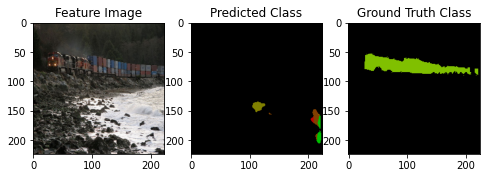

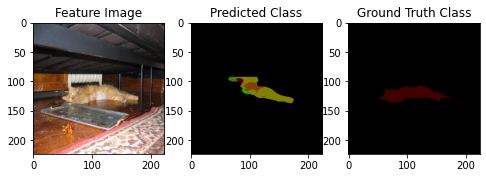

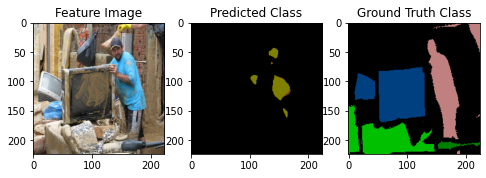

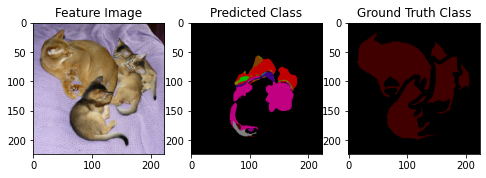

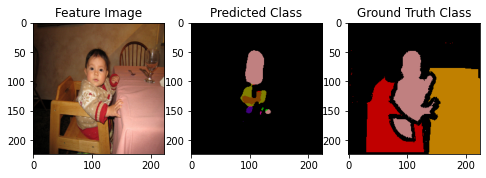

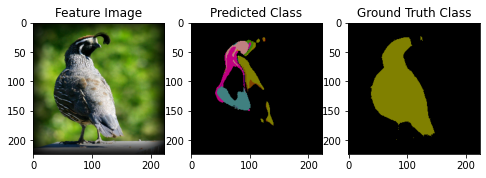

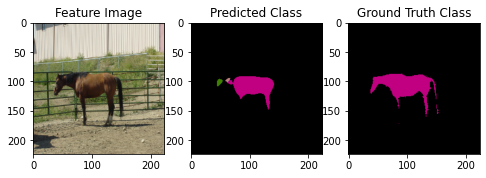

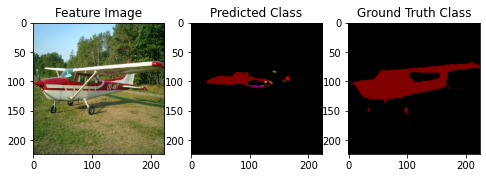

In [31]:
for i in range(50):
    plot_seg_out_pairs(Xtest_seg[i], y_pred_seg_scratch_max[i], Ytest_seg[i])

###1.1.2 Semantic Segmentation using Transfer Learning

To improve the pefromance of the segmentation model, we train the model using transfer learning. Just like the tranfer learning in classification, here we use VGG16 model with imagenet weights. These weights are freezed on the network layer. The VGG16 corresponds to only the encoder part of the network. Therefore, we freeze the weights only to the encoder part.

In [32]:
from keras.applications.vgg16 import VGG16

In [33]:
def unet_upSamplingblock(filter,input,concat,concat_encoder):
    up_conv = BatchNormalization()(Conv2D(filters=filter,kernel_size=(2,2),activation='relu',padding='same',
                                          kernel_initializer='he_normal')(UpSampling2D(size=(2,2),interpolation='bilinear')(input)))
    if concat:
        merge = concatenate([concat_encoder,up_conv])
    else:
        merge = up_conv
    conv1 = BatchNormalization()(Conv2D(filters=filter,kernel_size=(3,3),activation='relu',padding='same',
                                        kernel_initializer='he_normal')(merge))
    conv2 = BatchNormalization()(Conv2D(filters=filter, kernel_size=(3, 3), activation='relu', padding='same',
                                        kernel_initializer='he_normal')(conv1))

    return conv2


def unet(image_feature,vgg):
    conv1 = Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(image_feature)
    conv2 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    decoder_input = Dropout(0.5)(conv2)

    decoder1 = unet_upSamplingblock(filter=512,input=decoder_input,concat_encoder=vgg.get_layer('block5_conv3').output,concat=True)
    decoder2 = unet_upSamplingblock(filter=256,input=decoder1,concat_encoder=vgg.get_layer('block4_conv3').output,concat=True)
    decoder3 = unet_upSamplingblock(filter=128,input=decoder2,concat_encoder=vgg.get_layer('block3_conv2').output,concat=True)
    decoder4 = unet_upSamplingblock(filter=64,input=decoder3,concat_encoder=vgg.get_layer('block2_conv2').output,concat=True)
    decoder5 = unet_upSamplingblock(filter=64, input=decoder4, concat_encoder=vgg.get_layer('block1_conv2').output,concat=False)

    result = Conv2D(filters=n_classes,kernel_size=(1,1),activation='relu',padding='same',
                    kernel_initializer='he_normal',name='seg_output')(decoder5)

    return result

Here, we load the model with imagenet weights and freeze the network layers. It can be seen that in the model summary, the number of trainabe parameters are lesser comapred to the from the scratch model.

In [34]:
vgg = VGG16(weights='imagenet',include_top = False,input_shape=(image_size,image_size,3))
for layer in vgg.layers:
    layer.trainable = False
image_feature = vgg.output
result = unet(image_feature,vgg)

unet_model_tl = Model(vgg.input, result)
unet_model_tl.summary()



58892288/58889256 [==============================] - 5s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________

In [35]:
unet_model_tl.compile(optimizer=keras.optimizers.Adam(lr=learning_rate_seg,decay=learning_rate_seg/EPOCHS_seg),loss=dice_coef_loss, metrics=[dice_coef])

We train the model with similar settings as that of the model from the scratch. The training parameters like loss and metrics during the training process is plotted below.

In [36]:
seg_tl_model_history = unet_model_tl.fit(Xtrain_seg, Ytrain_seg, batch_size =  32, epochs = EPOCHS_seg, validation_split=(0.15), shuffle=True)


Train on 1146 samples, validate on 203 samples
Epoch 1/75
1146/1146 [==============================] - 32s 28ms/step - loss: 0.8665 - dice_coef: 0.1340 - val_loss: 0.9160 - val_dice_coef: 0.0832
Epoch 2/75
1146/1146 [==============================] - 26s 23ms/step - loss: 0.6694 - dice_coef: 0.3313 - val_loss: 0.9403 - val_dice_coef: 0.0603
Epoch 3/75
1146/1146 [==============================] - 26s 23ms/step - loss: 0.3713 - dice_coef: 0.6292 - val_loss: 0.9296 - val_dice_coef: 0.0737
Epoch 4/75
1146/1146 [==============================] - 26s 23ms/step - loss: 0.2068 - dice_coef: 0.7933 - val_loss: 0.7625 - val_dice_coef: 0.2425
Epoch 5/75
1146/1146 [==============================] - 26s 23ms/step - loss: 0.1664 - dice_coef: 0.8336 - val_loss: 0.5311 - val_dice_coef: 0.4699
Epoch 6/75
1146/1146 [==============================] - 26s 23ms/step - loss: 0.1507 - dice_coef: 0.8490 - val_loss: 0.4038 - val_dice_coef: 0.5968
Epoch 7/75
1146/1146 [==============================] - 26s 23ms/

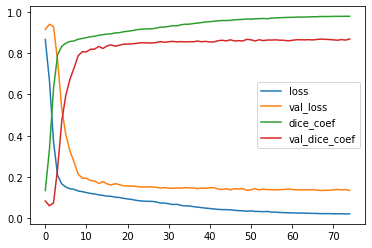

In [37]:
for key in ['loss', 'val_loss',  'dice_coef', 'val_dice_coef' ]:
    plt.plot(seg_tl_model_history.history[key],label=key)
plt.legend()
plt.show()

In [38]:
'''save_seg_tf_model_name = 'Segmentation_TransferLearning_Weights.h5'
unet_model_tl.save_weights('/content/gdrive/My Drive/'+save_seg_tf_model_name)'''

"save_seg_tf_model_name = 'Segmentation_TransferLearning_Weights.h5'\nunet_model_tl.save_weights('/content/gdrive/My Drive/'+save_seg_tf_model_name)"

In [39]:
y_pred_seg_tl = unet_model_tl.predict(Xtest_seg)
y_pred_seg_tl_max = np.argmax(y_pred_seg_tl, axis=3)

It can be seen that the model with tranfer learning obviously does a better job in segmenting the test sets. The **IOU** values are also higher comapred to the from the scratch model. The performance may not be so great but it is definitely better than the from the above from the scratch model. 

In [40]:
IoU(Ytest_seg,y_pred_seg_tl_max)

class background:            #TP=5858738,            #FP=532019,            #FN=193727,            IoU=0.890
class aeroplane:            #TP= 12125,            #FP=  6065,            #FN= 7240,            IoU=0.477
class bicycle:            #TP=     0,            #FP=    47,            #FN= 1050,            IoU=0.000
class bird:            #TP= 29023,            #FP= 24407,            #FN=16521,            IoU=0.415
class boat:            #TP= 32299,            #FP=  9093,            #FN=22168,            IoU=0.508
class bottle:            #TP=     2,            #FP=    14,            #FN=33700,            IoU=0.000
class bus:            #TP=140123,            #FP= 78925,            #FN=41720,            IoU=0.537
class car:            #TP= 56676,            #FP= 19812,            #FN=74749,            IoU=0.375
class cat:            #TP= 71529,            #FP= 47528,            #FN=57651,            IoU=0.405
class chair:            #TP=   349,            #FP= 32710,            #FN=13

Some of the predicted segmentations for test set are plotted here. The RGB color palette mapping may be accurate for all the classes but it acceptable.

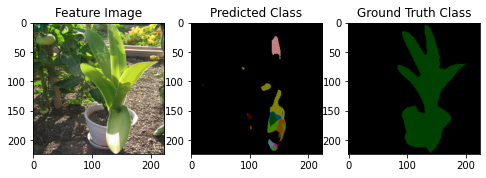

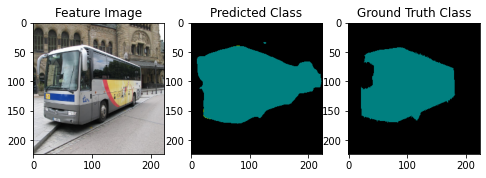

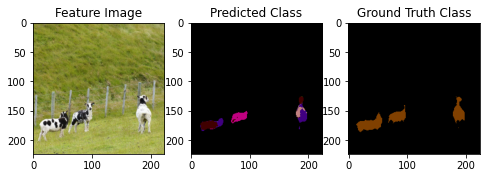

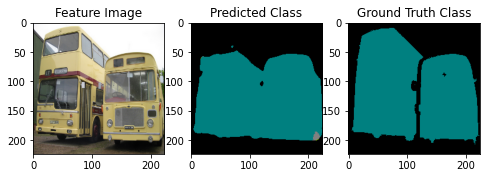

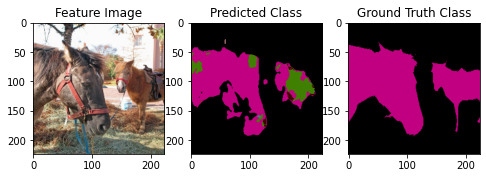

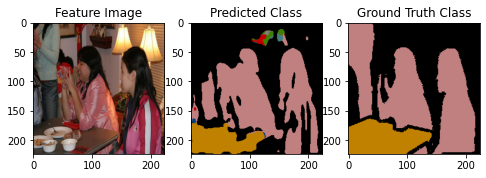

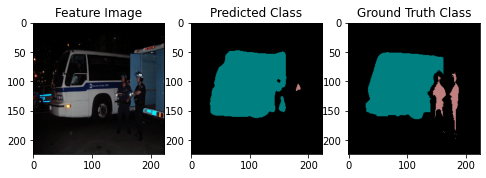

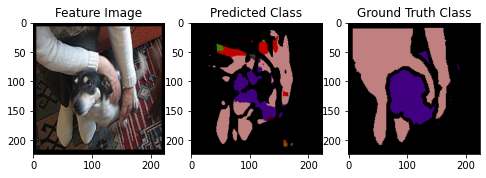

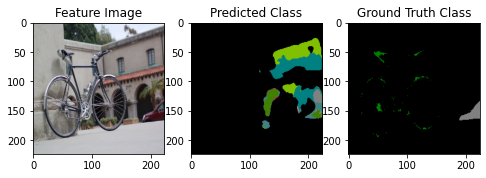

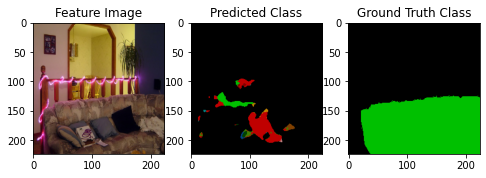

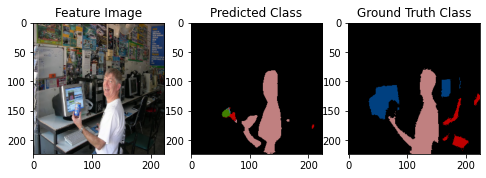

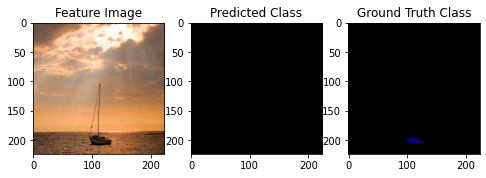

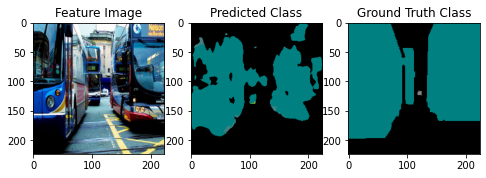

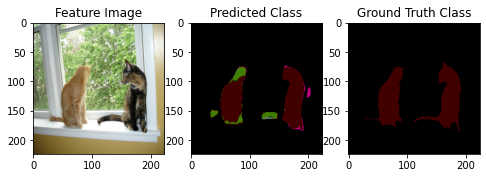

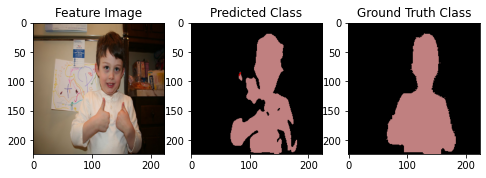

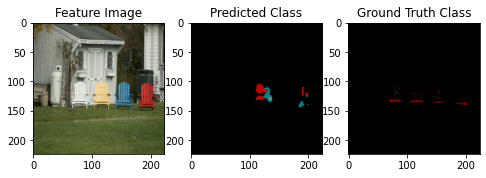

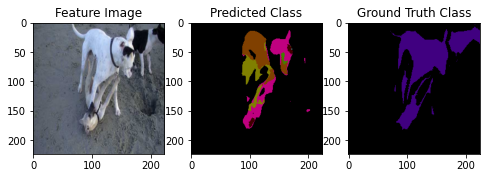

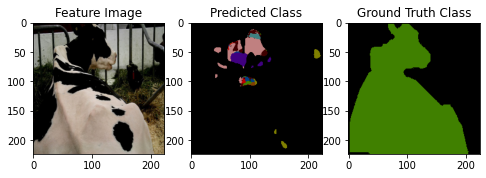

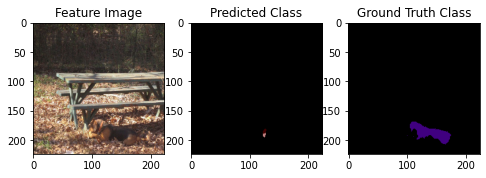

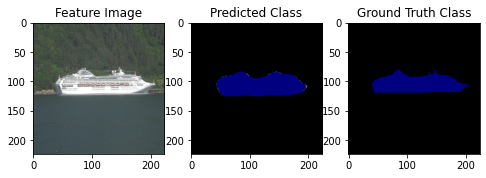

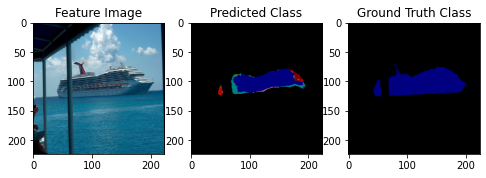

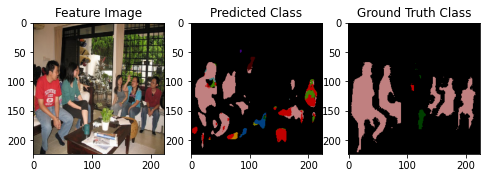

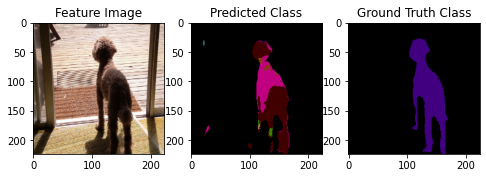

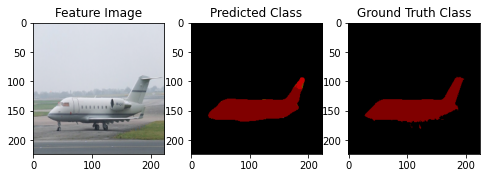

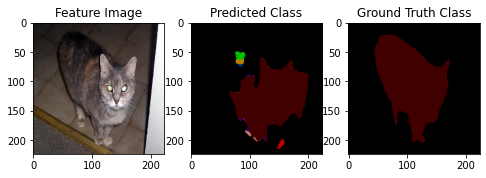

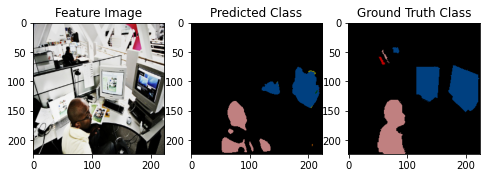

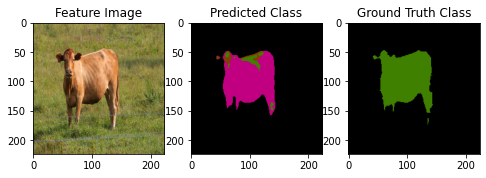

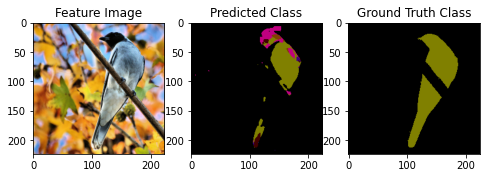

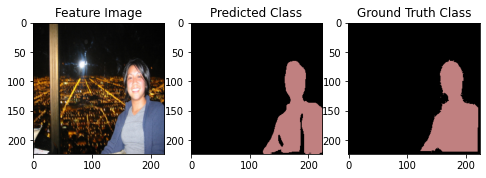

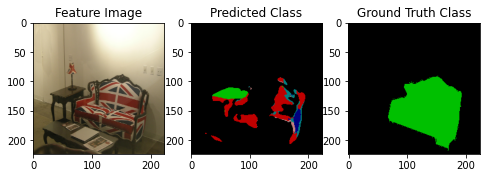

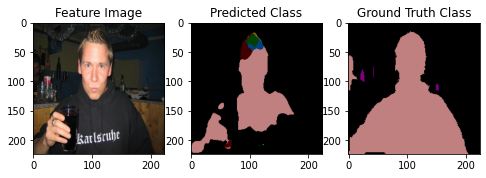

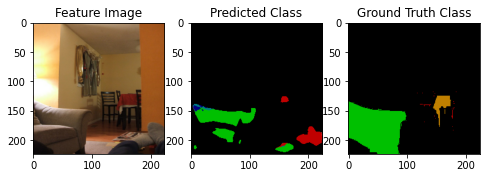

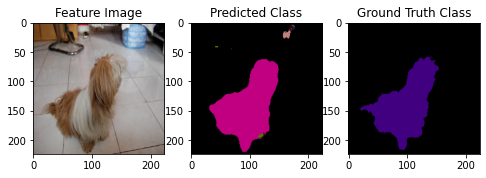

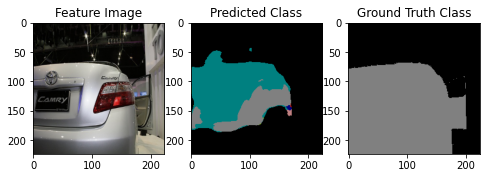

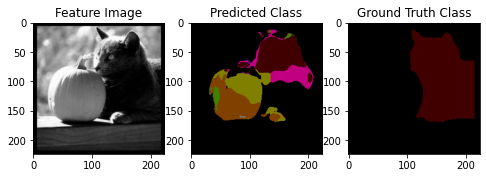

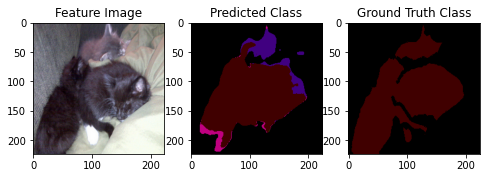

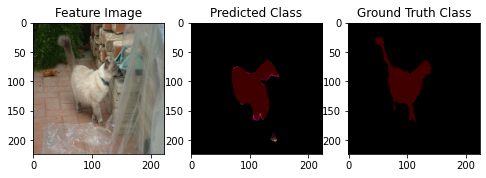

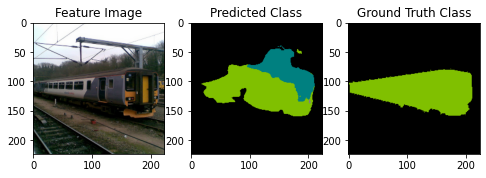

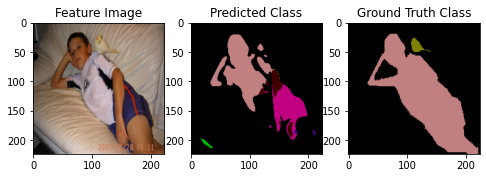

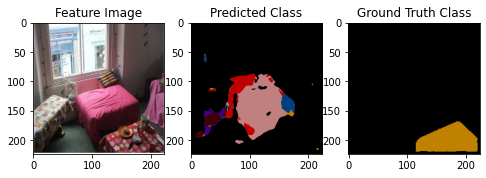

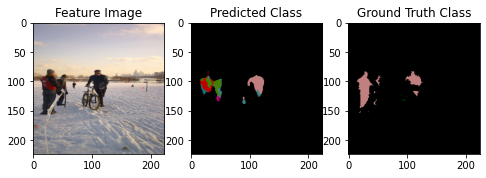

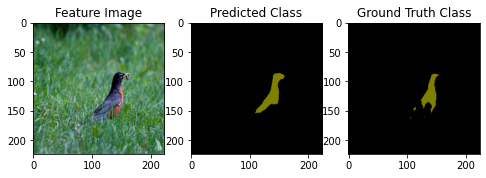

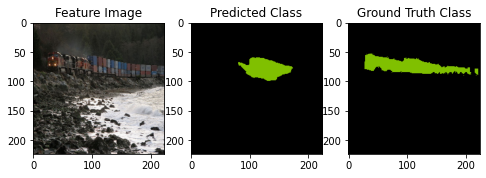

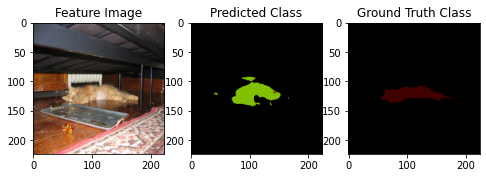

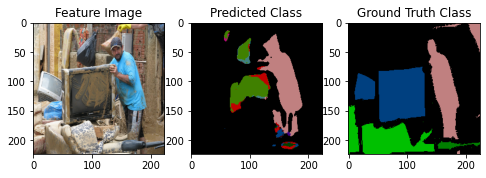

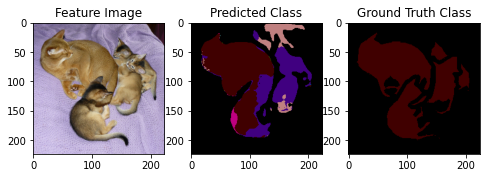

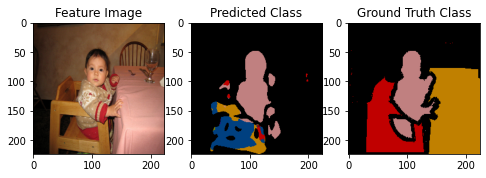

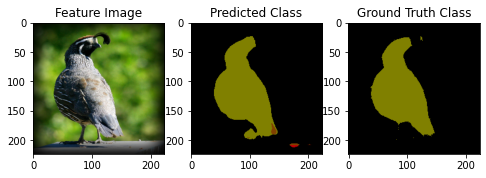

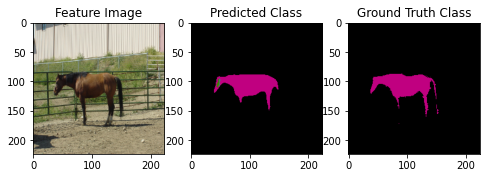

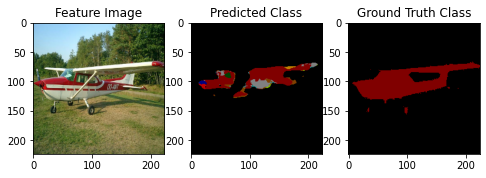

In [41]:
for i in range(50):
    plot_seg_out_pairs(Xtest_seg[i], y_pred_seg_tl_max[i], Ytest_seg[i])